In [1]:
import json, csv, os, ast
from os import listdir
from os.path import isfile, join
import random
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy as sp
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import wilcoxon
from IPython.display import display, HTML
import xml.etree.ElementTree
import seaborn as sns
import pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
from matplotlib import pyplot
from matplotlib import colors
from statsmodels.sandbox.stats.multicomp import multipletests
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(5,4)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
gold_dict = ['HIGH', 'LOW']

In [46]:
def get_dict(df, rel):
    df_lie = df.loc[df['rel'] == 'LIE']
    lie = df_lie['{}_rel'.format(rel)]
    df_false = df.loc[df['rel'] == 'FALSE']
    false = df_false['{}_rel'.format(rel)]
    df_barely = df.loc[df['rel'] == 'BARELYTRUE']
    barely = df_barely['{}_rel'.format(rel)]
    df_half = df.loc[df['rel'] == 'HALFTRUE']
    half = df_half['{}_rel'.format(rel)]
    df_mostly = df.loc[df['rel'] == 'MOSTLYTRUE']
    mostly = df_mostly['{}_rel'.format(rel)]
    df_true = df.loc[df['rel'] == 'TRUE']
    true = df_true['{}_rel'.format(rel)]
    my_dict = {'LIE' : lie, 'FALSE': false, 'BARELYTRUE': barely, 
               'HALFTRUE': half, 'MOSTLYTRUE': mostly, 'TRUE': true}
    order = ['LIE', 'FALSE', 'BARELYTRUE', 'HALFTRUE', 'MOSTLYTRUE','TRUE']
    return my_dict, order

def get_pvalues(my_dict, order):
    o = order.copy()
    stat_list_S6 = []
    p_list_S6 = []
    for i in my_dict:
        for j in my_dict:
            #print("{} | {}".format(i,j))
            stat, p = stats.ttest_ind(my_dict[i], my_dict[j], equal_var = False)
            stat_list_S6.append(stat)
            p_list_S6.append(p)
            #print(p)
    p_adj_S6 = multipletests(p_list_S6, method='bonferroni')
    print("done.")
    return p_adj_S6

def ttest_heat(p_adj_S6, rel, name):
    labels = ['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True']
    cmap = colors.ListedColormap(['#03051A', '#FAEBDD', '#ED4E3E'])
    tr = []
    for i in p_adj_S6[1]:
        label = 0
        if i >= 0.05:
            label = 3
        elif 0.01 <= i < 0.05:
            label = 2
        elif i < 0.01:
            label = 1
        tr.append(label)
    p = np.reshape(tr, (6, 6))
    mask = np.zeros_like(p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    pages = PdfPages("../../plots/BigTask/Significance/New/{}_ttest_heatmap_{}.pdf".format(name, rel))
    ax = sns.heatmap(p, mask = mask, linewidths = .5, cmap = cmap)
    ax.set_title("{} \np-values for {} Scale, Bonferroni Corrected".format(name, rel))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation = 360)
    ax.collections[0].colorbar.set_label("p <0.01     0.01 <= p < 0.05     p > 0.05")
    ax.collections[0].colorbar.set_ticks([])
    pages.savefig(bbox_inches = 'tight')
    pages.close()

def merge_df(dem_df, rep_df, rel):
    df = rep_df
    df = df[df["rel"].isin(gold_dict) == False]
    df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
    merged_r = df[['doc_id', '{}_rel'.format(rel), 'rel']].groupby(['doc_id']).agg('mean').reset_index()
    merged_r['worker_party'] = 'REP'

    df = dem_df
    df = df[df["rel"].isin(gold_dict) == False]
    df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
    # DEMOCRATICI SU TUTTI GLI STATEMENT
    merged_d = df[['doc_id', '{}_rel'.format(rel), 'rel']].groupby(['doc_id']).agg('mean').reset_index()
    merged_d['worker_party'] = 'DEM'

    merged = pd.concat([merged_d, merged_r])
    return merged

def get_label(string):
    s = string.split("_")
    return s[1]

In [47]:
rel = 'S100'
df = pd.read_csv('../../Task/BigTask/Poli_{}.csv'.format(rel))
display(df.head())
df = df[df["rel"].isin(gold_dict) == False]
if(rel == "S100"):
    df =  df.dropna()
    df["{}_rel".format(rel)] = df["{}_rel".format(rel)].astype(int)

merged = df[['doc_id', "{}_rel".format(rel), 'rel']].groupby(['doc_id']).agg('mean').reset_index()
display(df.head(2))
merged['rel'] = merged.apply(lambda row: get_label(row.doc_id), axis = 1)
print(df.shape[0])
display(merged.head())

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time
0,unit_0,DEM_HALFTRUE_doc3,HALFTRUE,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,4,2.0,Looks like it went up 170%.according to Politi...,www.politifact.com,1,74.97.48.154,147.263
1,unit_0,REP_MOSTLYTRUE_doc5,MOSTLYTRUE,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,7,93.0,"He said that in a January 28, 2008, speech.",www.politifact.com,3,74.97.48.154,125.867
2,unit_1,REP_TRUE_doc8,TRUE,A10LHWALI4BZPC,1,3,6,9,1,1,2,1,1,1,100.0,\r\r\nThe average annual pension benefit for n...,www.politifact.com,0,73.129.121.170,25.925
3,unit_1,REP_FALSE_doc2,FALSE,A10LHWALI4BZPC,1,3,6,9,1,1,2,1,1,3,10.0,"Richardson, in criticizing Kitzhaber’s years a...",www.politifact.com,0,73.129.121.170,21.817
4,unit_1,DEM_BARELYTRUE_doc9,BARELYTRUE,A10LHWALI4BZPC,1,3,6,9,1,1,2,1,1,4,19.0,"McAuliffe did not acknowledge these points, al...",www.politifact.com,0,73.129.121.170,25.283


,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time
0,unit_0,DEM_HALFTRUE_doc3,HALFTRUE,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,4,2,Looks like it went up 170%.according to Politi...,www.politifact.com,1,74.97.48.154,147.263
1,unit_0,REP_MOSTLYTRUE_doc5,MOSTLYTRUE,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,7,93,"He said that in a January 28, 2008, speech.",www.politifact.com,3,74.97.48.154,125.867


868


,doc_id,S100_rel,rel
0,DEM_BARELYTRUE_doc1,58.600000,BARELYTRUE
1,DEM_BARELYTRUE_doc10,38.833333,BARELYTRUE
2,DEM_BARELYTRUE_doc2,47.500000,BARELYTRUE
3,DEM_BARELYTRUE_doc3,40.375000,BARELYTRUE
4,DEM_BARELYTRUE_doc4,46.400000,BARELYTRUE


done.


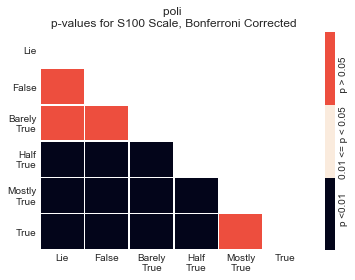

In [48]:
my_dict, order = get_dict(df, rel)
p_adj = get_pvalues(my_dict, order)
ttest_heat(p_adj, rel, 'poli')

done.


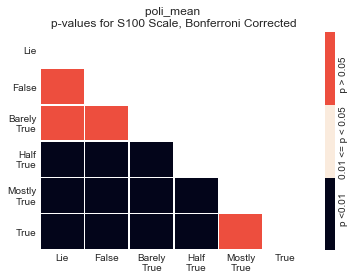

In [49]:
my_dict, order = get_dict(merged, rel)
p_adj = get_pvalues(my_dict, order)
ttest_heat(p_adj, rel, 'poli_mean')

In [8]:
# S6
o = order.copy()
stat_list_S6 = []
p_list_S6 = []
for i in my_dict:
    for j in my_dict:
        #if(i != j):
        print("{} | {}".format(i,j))
        stat, p = stats.ttest_ind(my_dict[i], my_dict[j], equal_var = False)
        stat_list_S6.append(stat)
        p_list_S6.append(p)
        print(p)
    #o.remove(i)

p_adj_S6 = multipletests(p_list_S6, method='bonferroni')
print(p_adj_S6)

LIE | LIE
1.0
LIE | FALSE
0.0897044792992167
LIE | BARELYTRUE
0.03766478358880563
LIE | HALFTRUE
0.14413573598249443
LIE | MOSTLYTRUE
4.351425283873842e-05
LIE | TRUE
0.054009480612244094
FALSE | LIE
0.0897044792992167
FALSE | FALSE
1.0
FALSE | BARELYTRUE
0.9013723268188656
FALSE | HALFTRUE
0.7430220239370402
FALSE | MOSTLYTRUE
0.04510530505440164
FALSE | TRUE
0.9915860184791594
BARELYTRUE | LIE
0.03766478358880563
BARELYTRUE | FALSE
0.9013723268188656
BARELYTRUE | BARELYTRUE
1.0
BARELYTRUE | HALFTRUE
0.6130876253688968
BARELYTRUE | MOSTLYTRUE
0.029165072450107615
BARELYTRUE | TRUE
0.8974490623360986
HALFTRUE | LIE
0.14413573598249443
HALFTRUE | FALSE
0.7430220239370402
HALFTRUE | BARELYTRUE
0.6130876253688968
HALFTRUE | HALFTRUE
1.0
HALFTRUE | MOSTLYTRUE
0.011885933043332029
HALFTRUE | TRUE
0.7050331023425758
MOSTLYTRUE | LIE
4.351425283873842e-05
MOSTLYTRUE | FALSE
0.04510530505440164
MOSTLYTRUE | BARELYTRUE
0.029165072450107615
MOSTLYTRUE | HALFTRUE
0.011885933043332029
MOSTLYTRUE |

[Text(0,0.5,'Lie'),
 Text(0,1.5,'False'),
 Text(0,2.5,'Barely\nTrue'),
 Text(0,3.5,'Half\nTrue'),
 Text(0,4.5,'Mostly\nTrue'),
 Text(0,5.5,'True')]

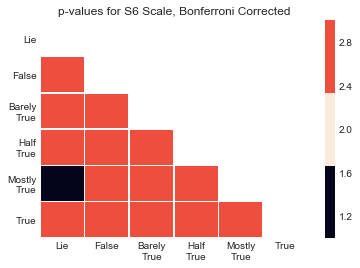

In [9]:
labels = ['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True']
cmap = colors.ListedColormap(['#03051A', '#FAEBDD', '#ED4E3E'])

tr = []
for i in p_adj_S6[1]:
    label = 0
    if i >= 0.05:
        label = 3
    elif 0.01 <= i < 0.05:
        label = 2
    elif i < 0.01:
        label = 1
    tr.append(label)

p = np.reshape(tr, (6, 6))
mask = np.zeros_like(p, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#assert False
#pages = PdfPages(f'../../plots/BigTask/Significance/ttest_heatmap_S6.pdf'.format())
ax = sns.heatmap(p, mask = mask, linewidths = .5, cmap = cmap)
ax.set_title("p-values for S6 Scale, Bonferroni Corrected")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels, rotation = 360)
#pages.savefig(bbox_inches = 'tight')
#pages.close()

In [62]:
df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
df = df.dropna()
df = df[df["rel"].isin(gold_dict) == False]
o = order.copy()
df_lie = df.loc[df['rel'] == 'LIE']
lie = df_lie['S100_rel']
df_false = df.loc[df['rel'] == 'FALSE']
false = df_false['S100_rel']
df_barely = df.loc[df['rel'] == 'BARELYTRUE']
barely = df_barely['S100_rel']
df_half = df.loc[df['rel'] == 'HALFTRUE']
half = df_half['S100_rel']
df_mostly = df.loc[df['rel'] == 'MOSTLYTRUE']
mostly = df_mostly['S100_rel']
df_true = df.loc[df['rel'] == 'TRUE']
true = df_true['S100_rel']
my_dict = {'LIE' : lie, 'FALSE': false, 'BARELYTRUE': barely, 
           'HALFTRUE': half, 'MOSTLYTRUE': mostly, 'TRUE': true}
order = ['LIE', 'FALSE', 'BARELYTRUE', 'HALFTRUE', 'MOSTLYTRUE','TRUE']
# S100
stat_list_S100 = []
p_list_S100 = []
for i in my_dict:
    for j in my_dict:
        #if(i != j):
        stat, p = stats.ttest_ind(my_dict[i], my_dict[j], equal_var = False)
        stat_list_S100.append(stat)
        p_list_S100.append(p)
    #o.remove(i)
p_adj_S100 = multipletests(p_list_S100, method='bonferroni')
print(p_adj_S100)

(array([False, False, False,  True,  True,  True, False, False, False,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.49804326e-10,
       7.97376436e-22, 3.45280436e-27, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 3.93437629e-10, 1.08655123e-22, 3.66375233e-28,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 7.87431877e-07,
       2.31625307e-19, 5.23370806e-25, 9.49804326e-10, 3.93437629e-10,
       7.87431877e-07, 1.00000000e+00, 1.07861925e-04, 2.22216660e-09,
       7.97376436e-22, 1.08655123e-22, 2.31625307e-19, 1.07861925e-04,
       1.00000000e+00, 6.76208961e-01, 3.45280436e-27, 3.66375233e-28,
       5.23370806e-25, 2.22216660e-09, 6.76208961e-01, 1.00000000e+00]), 0.0014237991678133222, 0.001388888888888889)


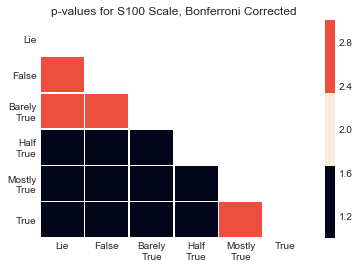

In [9]:
labels = ['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True']
cmap = colors.ListedColormap(['#03051A', '#FAEBDD', '#ED4E3E'])

tr = []
for i in p_adj_S100[1]:
    label = 0
    if i >= 0.05:
        label = 3
    elif 0.01 <= i < 0.05:
        label = 2
    elif i < 0.01:
        label = 1
    tr.append(label)
    
p = np.reshape(tr, (6, 6))
mask = np.zeros_like(p, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



pages = PdfPages(f'../../plots/BigTask/Significance/ttest_heatmap_S100.pdf'.format())
ax = sns.heatmap(p, mask = mask, linewidths = .5, cmap = cmap)
ax.set_title("p-values for S100 Scale, Bonferroni Corrected")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels, rotation = 360)
pages.savefig(bbox_inches = 'tight')
pages.close()

In [13]:
def get_dict(df, rel):
    df_lie = df.loc[df['rel'] == 'LIE']
    lie = df_lie['{}_rel'.format(rel)]
    df_half = df.loc[df['rel'] == 'HALFTRUE']
    half = df_half['{}_rel'.format(rel)]
    df_true = df.loc[df['rel'] == 'TRUE']
    true = df_true['{}_rel'.format(rel)]
    my_dict = {'LIE' : lie, 'HALFTRUE': half, 'TRUE': true}
    order = ['LIE', 'HALFTRUE','TRUE']
    return my_dict, order

def get_pvalues(my_dict, order):
    o = order.copy()
    stat_list_S6 = []
    p_list_S6 = []
    for i in my_dict:
        for j in my_dict:
            #print("{} | {}".format(i,j))
            stat, p = stats.ttest_ind(my_dict[i], my_dict[j], equal_var = False)
            stat_list_S6.append(stat)
            p_list_S6.append(p)
            #print(p)
    p_adj_S6 = multipletests(p_list_S6, method='bonferroni')
    print("done.")
    return p_adj_S6

def ttest_heat(p_adj_S6, rel, name):
    labels = ['Lie\nFalse', 'Barely\nHalf', 'Moslty\nTrue']
    cmap = colors.ListedColormap(['#03051A', '#FAEBDD', '#ED4E3E'])
    tr = []
    for i in p_adj_S6[1]:
        label = 0
        if i >= 0.05:
            label = 3
        elif 0.01 <= i < 0.05:
            label = 2
        elif i < 0.01:
            label = 1
        tr.append(label)
    p = np.reshape(tr, (3, 3))
    mask = np.zeros_like(p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    pages = PdfPages("../../plots/BigTask/Significance/New/{}_ttest_heatmap_{}.pdf".format(name, rel))
    ax = sns.heatmap(p, mask = mask, linewidths = .5, cmap = cmap)
    ax.set_title("{} \np-values for {} Scale, Bonferroni Corrected".format(name, rel))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation = 360)
    ax.collections[0].colorbar.set_label("p <0.01     0.01 <= p < 0.05     p > 0.05")
    ax.collections[0].colorbar.set_ticks([])
    pages.savefig(bbox_inches = 'tight')
    pages.close()

def get_label(string):
    s = string.split("_")
    return s[1]

In [27]:
rel = 'S100'
df = pd.read_csv('../../Task/BigTask/Not_Poli_{}.csv'.format(rel))
df = df[df["rel"].isin(gold_dict) == False]
if(rel == "S100"):
    df =  df.dropna()
    df["{}_rel".format(rel)] = df["{}_rel".format(rel)].astype(int)
df = df.replace('FALSE', 'LIE').replace('BARELYTRUE', 'HALFTRUE').replace('MOSTLYTRUE', 'TRUE')
display(df.head())

merged = df[['doc_id', "{}_rel".format(rel), 'rel']].groupby(['doc_id']).agg('mean').reset_index()
display(df.head(2))
merged['rel'] = merged.apply(lambda row: get_label(row.doc_id), axis = 1)
display(merged.head())

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,...,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time,_merge
0,unit_0,REP_LIE_doc6,LIE,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,1,3,"Rick Perry was governor of Texas, not Massachu...",en.wikipedia.org,0,74.97.48.154,59.715,left_only
1,unit_0,DEM_FALSE_doc1,LIE,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,2,6,Nancy Pelosi is House Majority leader and Spea...,www.facebook.com,1,74.97.48.154,85.715,left_only
3,unit_0,DEM_TRUE_doc2,TRUE,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,5,40,I cannot find anything that supports this as f...,www.vanityfair.com,3,74.97.48.154,291.685,left_only
5,unit_0,REP_BARELYTRUE_doc4,HALFTRUE,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,8,88,Politifact confirms this.,www.texasstandard.org,2,74.97.48.154,78.217,left_only
8,unit_2,DEM_TRUE_doc2,TRUE,A3LMA3YJDQUZP2,1,4,3,9,1,1,...,1,1,2,0,nytimes is a good source usually,www.nytimes.com,1,24.228.128.135,67.948,left_only


,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,...,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time,_merge
0,unit_0,REP_LIE_doc6,LIE,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,1,3,"Rick Perry was governor of Texas, not Massachu...",en.wikipedia.org,0,74.97.48.154,59.715,left_only
1,unit_0,DEM_FALSE_doc1,LIE,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,2,6,Nancy Pelosi is House Majority leader and Spea...,www.facebook.com,1,74.97.48.154,85.715,left_only


,doc_id,S100_rel,rel
0,DEM_BARELYTRUE_doc1,53.8,BARELYTRUE
1,DEM_BARELYTRUE_doc10,65.5,BARELYTRUE
2,DEM_BARELYTRUE_doc2,53.5,BARELYTRUE
3,DEM_BARELYTRUE_doc3,67.0,BARELYTRUE
4,DEM_BARELYTRUE_doc5,52.5,BARELYTRUE


done.


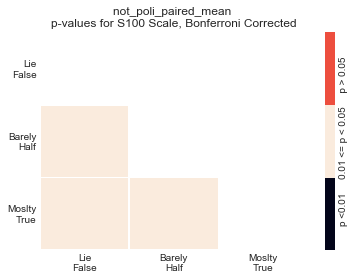

In [29]:
my_dict, order = get_dict(merged, rel)
p_adj = get_pvalues(my_dict, order)
ttest_heat(p_adj, rel, 'not_poli_paired_mean')